In [1]:
import artm
import re
import numpy as np
import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import pymorphy2

morph = pymorphy2.MorphAnalyzer()

def clean_text(text):
    cleaned_text = np.array([])
    for t in tqdm.tqdm_notebook(text):
        t = re.sub("[^а-яА-Яa-zA-Z0-9_ ]", "", t).lower()
        t = normalization(t)
        cleaned_text = np.append(cleaned_text, t)
    return cleaned_text

def normalization(text):
    new_text = []
    for t in text.split(" "):
        new_text.append(morph.parse(t)[0].normal_form)
    return (" ").join(new_text)

def del_stop_words(text, stop_words=None):
    stop_text = []
    for t in tqdm.tqdm(text):
        words = t.split(" ")
        clear_text = []
        for word in words:
            if word not in stop_words:
                clear_text.append(word)
        t = (" ").join(clear_text)
        stop_text.append(t)
    return stop_text

def create_stop_words(text):
    tfidf = TfidfVectorizer()
    X = tfidf.fit_transform(text)
    N = 50
    idx = np.ravel(X.sum(axis=0).argsort(axis=1))[::-1][-N:]
    recent_words = np.array(tfidf.get_feature_names())[idx].tolist()
    with open('ya_stop_words.txt', "rt", encoding="utf-8") as f:
        ya_stop = list([l.replace("\n", "") for l in f.readlines()])
    with open('stop_words.txt', "rt", encoding="utf-8") as f:
        top_words = list([l.replace("\n", "") for l in f.readlines()])  
    alphabet = ['а', 'б', 'в', 'г', 'д', 'е', 'ё', 'ж', 'з', 'и',
                'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у',
                'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э',
                'ю', 'я']   
    stop_words = top_words + recent_words + alphabet + ya_stop
    return stop_words

def del_short_msg(text, size):
    new_text = []
    good_ind = []
    for i,t in tqdm.tqdm(enumerate(text)):
        if (len(re.split(" ", t)) >= size):
            new_text.append(t)
            good_ind.append(i)
    return new_text, good_ind

In [2]:
with open('lines.txt', "rt", encoding="utf-8") as f:
    original_text = np.array(list([l.replace("\n", "") for l in f.readlines()]))

In [3]:
original_text = [x for x in original_text if x != '']

In [4]:
len(original_text)

7122

In [5]:
cleaned_text = clean_text(original_text)

HBox(children=(IntProgress(value=0, max=7122), HTML(value='')))

In [6]:
stop_words = create_stop_words(cleaned_text)
text = cleaned_text
for i in range(5):
    text = np.array(del_stop_words(text, stop_words))

100%|██████████| 7122/7122 [00:01<00:00, 3907.62it/s]


In [7]:
text, ind = del_short_msg(text, 15)

7122it [00:00, 79746.47it/s]


In [8]:
new_text = []
for t in text:
    new_text.append(" |text " + t + " ")

In [9]:
file = 'ba.txt'
with open(file, "w", encoding="utf-8") as f:
    f.writelines("\n".join(new_text))

In [10]:
batch_vectorizer = artm.BatchVectorizer(data_path=file, data_format="vowpal_wabbit", target_folder="batches")

In [11]:
with open(file, "rt", encoding="utf-8") as f:
    text = np.array(sorted(list(([l.replace("\n", "") for l in f.readlines()]))))

In [12]:
len(text)

3471

In [13]:
dictionary = artm.Dictionary('dictionary')
dictionary.gather(batch_vectorizer.data_path)
dictionary.save_text(dictionary_path='dictionary.txt')

#dictionary.load_text(dictionary_path='dictionary.txt')

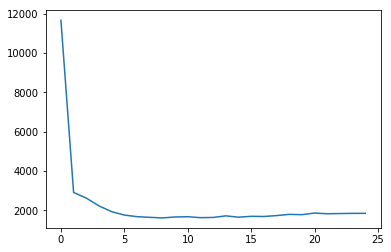

0.8880344033241272
0.7159769535064697


In [14]:
T=25
model_artm = artm.ARTM(num_topics=T, topic_names=[str(i) for i in range(T)], class_ids={"text":1}, 
                                       num_document_passes=3, reuse_theta=True, cache_theta=True, seed=-1)
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                           dictionary='dictionary'))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore', class_id="text"))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopTokensScore(name="top_words", num_tokens=6, class_id="text"))
model_artm.initialize('dictionary')
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=20)
model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorr'))
model_artm.regularizers['decorr'].tau = 0.01
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=5)
plt.plot(model_artm.score_tracker["PerplexityScore"].value)
plt.show()
theta = model_artm.get_theta()
tok = model_artm.score_tracker["top_words"].last_tokens
weights = model_artm.score_tracker["top_words"].last_weights
print(model_artm.score_tracker["SparsityPhiScore"].last_value)
print(model_artm.score_tracker["SparsityThetaScore"].last_value)

In [15]:
themas = list(model_artm.score_tracker["top_words"].last_tokens.keys())

In [16]:
for thema in np.sort([int(t) for t in themas]):
    print("__________________________________________________________________")
    print("тема номер ", thema)
    print("__________________________________________________________________")
    for i in range(6):
        print(model_artm.score_tracker['top_words'].last_tokens[str(thema)][i],
              model_artm.score_tracker['top_words'].last_weights[str(thema)][i])

__________________________________________________________________
тема номер  1
__________________________________________________________________
спортсмен 0.007320451084524393
дом 0.006508564576506615
жить 0.006122310645878315
россия 0.005985551979392767
никогда 0.0055905673652887344
советский 0.005320070311427116
__________________________________________________________________
тема номер  2
__________________________________________________________________
письмо 0.01452464610338211
россия 0.009649060666561127
думать 0.00867997482419014
плюс 0.007675184402614832
столица 0.007304970175027847
постсоветский 0.007286005187779665
__________________________________________________________________
тема номер  5
__________________________________________________________________
должный 0.007541394326835871
страна 0.005955693311989307
другой 0.0055724866688251495
россия 0.005311886314302683
работать 0.005244419444352388
уровень 0.004848454613238573
________________________________________

In [17]:
theta = model_artm.get_theta()
phi = model_artm.get_phi()

In [18]:
phi.to_csv('phi.csv')

In [19]:
theta.to_csv('theta.csv')

In [20]:
z = sorted(list(theta.columns))

In [21]:
for t in themas:
    f = open('results/{}.txt'.format(t), mode='w')
    for i in range(theta.shape[1]):
        if theta[z[i]].idxmax() == t and theta[z[i]].max() >= 0.8:
            if i == z[i]:
                f.write(original_text[ind[i]] + '\n\n')
            else:
                pass
        else:
            pass
        